In [2]:
# Import some libraries
import os
import numpy as np
import mne
import glob
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib qt 

# define dir
data_directory = 'C:/Users/mvmigem/Documents/data/project_1/preprocessed/localiser/'
dir_list = glob.glob(data_directory+'*')

In [3]:
# Load epochs
epochs = []
subjects = []
# Specify the epoch length we will be looking at
epoch_tmin = -0.1
epoch_tmax = 0.5
for i, path in enumerate(dir_list):
    sub = int(dir_list[i].split('sub')[1].split('_localiser-epo.fif')[0])
    subjects.append(sub)
    epoch = mne.read_epochs(path).crop(tmin=epoch_tmin,tmax=epoch_tmax).apply_baseline()
    epochs.append(epoch)


Reading C:\Users\mvmigem\Documents\data\project_1\preprocessed\localiser\sub01_localiser-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
233 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Reading C:\Users\mvmigem\Documents\data\project_1\preprocessed\localiser\sub02_localiser-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Reading C:\Users\mvmigem\Documents\data\project_1\preprocessed\localiser\sub03_localiser-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
240 matching events f

In [4]:
# Agragate over over all trials directly
ep_pos1 = []
ep_pos2 = []
ep_pos3 = []
ep_pos4 = []

for i, epoch in enumerate(epochs):
    ep_pos1.append(epoch['position1'])
    ep_pos2.append(epoch['position2'])
    ep_pos3.append(epoch['position3'])
    ep_pos4.append(epoch['position4'])

eps_pos1 = mne.concatenate_epochs(ep_pos1)
eps_pos2 = mne.concatenate_epochs(ep_pos2)
eps_pos3 = mne.concatenate_epochs(ep_pos3)
eps_pos4 = mne.concatenate_epochs(ep_pos4)

av_ep_pos1 = eps_pos1.average()
av_ep_pos2 = eps_pos2.average()
av_ep_pos3 = eps_pos3.average()
av_ep_pos4 = eps_pos4.average()

Not setting metadata
1452 matching events found
Applying baseline correction (mode: mean)


C:\Users\mvmigem\AppData\Local\Temp\ipykernel_25520\2241026841.py:13: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  eps_pos1 = mne.concatenate_epochs(ep_pos1)
C:\Users\mvmigem\AppData\Local\Temp\ipykernel_25520\2241026841.py:14: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  eps_pos2 = mne.concatenate_epochs(ep_pos2)


Not setting metadata
1458 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
1465 matching events found
Applying baseline correction (mode: mean)


C:\Users\mvmigem\AppData\Local\Temp\ipykernel_25520\2241026841.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  eps_pos3 = mne.concatenate_epochs(ep_pos3)
C:\Users\mvmigem\AppData\Local\Temp\ipykernel_25520\2241026841.py:16: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  eps_pos4 = mne.concatenate_epochs(ep_pos4)


Not setting metadata
1456 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [5]:
# Agragate over subs first
evokeds = []

for i, ep in enumerate(epochs):
    
    evoked_pos1 = ep['position1'].average()
    evoked_pos2 = ep['position2'].average()
    evoked_pos3 = ep['position3'].average()
    evoked_pos4 = ep['position4'].average()
    
    evoked = [evoked_pos1, evoked_pos2, evoked_pos3, evoked_pos4]
    evokeds.append(evoked)
evokeds = np.array(evokeds)
grand_av_pos1 = mne.grand_average(list(evokeds[:,0]))
grand_av_pos2 = mne.grand_average(list(evokeds[:,1]))
grand_av_pos3 = mne.grand_average(list(evokeds[:,2]))
grand_av_pos4 = mne.grand_average(list(evokeds[:,3]))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

In [5]:
# check positioning is correct
scale = [-12,12]
for i in range(25):
    av_list = [evokeds[i,0],evokeds[i,1],evokeds[i,2],evokeds[i,3]]
    # grand_av_list = [av_ep_pos1, av_ep_pos2, av_ep_pos3, av_ep_pos4]
    conds = ('position1','position2','position3','position4')
    av_list = dict(zip(conds, av_list))
    mne.viz.plot_compare_evokeds(av_list, picks= 'POz', vlines=[0.05,0.1],ylim=dict(eeg=scale))

c:\Users\mvmigem\AppData\Local\miniconda3\envs\mne\lib\site-packages\mne\viz\evoked.py:2947: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  axes = (plt.subplots(figsize=(8, 6))[1] for _ in ch_types)


In [6]:
i = 16
av_list = [evokeds[i,0],evokeds[i,1],evokeds[i,2],evokeds[i,3]]
scale=[-10,10]
grand_av_list = [av_ep_pos1, av_ep_pos2, av_ep_pos3, av_ep_pos4]
conds = ('position1','position2','position3','position4')
av_list = dict(zip(conds, grand_av_list))
mne.viz.plot_compare_evokeds(av_list, picks= 'POz', vlines=[0.05,0.1],ylim=dict(eeg=scale))

[<Figure size 800x600 with 2 Axes>]

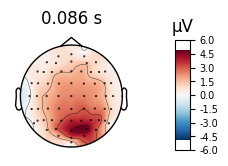

In [7]:
times = np.linspace(0.086, 0.09, 1)


grand_av_pos1.plot_topomap(ch_type="eeg", times=times, colorbar=True)
grand_av_pos2.plot_topomap(ch_type="eeg", times=times, colorbar=True)
grand_av_pos3.plot_topomap(ch_type="eeg", times=times, colorbar=True)
grand_av_pos4.plot_topomap(ch_type="eeg", times=times, colorbar=True)

In [8]:
# Find peak properties to find individual tailored c1 window 
merged_ev_for_peak =[]

all_pos = []
peak_properties = ['peak_channel','peak_latency','peak_amplitude']

roi_channels = ['Oz','O1','O2',
                'PO3','POz','PO4',
                'P1','Pz','P2',
                'CP1','CPz','CP2',
                ]

# get peak properties of agragated erps
for i in range(25):
    av_list = list(evokeds[i,:])

    # rsq_ev_list = av_list.copy()
    for i,evoked in enumerate(av_list):
        # transform data to root squared
        ev_data = evoked.data
        rootsqr_data = np.sqrt((ev_data**2))
        rsq_ev = mne.EvokedArray(rootsqr_data,evoked.info,tmin=evoked.times[0])
        av_list[i] = rsq_ev

    merged_ev = mne.grand_average(av_list).pick(roi_channels)
    ch,lat,amp = merged_ev.get_peak(ch_type='eeg',   
                                tmin=0.06,tmax=0.09,
                                return_amplitude=True)
    all_pos.append(dict(zip(peak_properties,(ch,lat,amp))))

    merged_ev_for_peak.append(merged_ev)

    conds = ('merged')
    evoked_pos = {conds:merged_ev}
    epoch_set1 = evoked_pos
    scale = [-10, 10]
    # mne.viz.plot_compare_evokeds(epoch_set1, picks= 'Pz', vlines=[0.05,0.1],ylim=dict(eeg=scale))
    # mne.viz.plot_compare_evokeds(epoch_set1,picks='POz',vlines=[0.05,0.1],ylim=dict(eeg=scale))
grand_av_merged = mne.grand_average(merged_ev_for_peak)


Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


In [9]:
grand_peak_ch_name, grand_peak_latency, grand_peak_amplitude = grand_av_merged.get_peak(ch_type='eeg',tmin=0.06,tmax=0.09,return_amplitude=True)

In [10]:
# get peak properties for every subject per position
pos1 = []
pos2 = []
pos3 = []
pos4 = []

positions = [pos1,pos2,pos3,pos4]
peak_properties = ['peak_channel','peak_latency','peak_amplitude']

for i in range(25):
    av_list = list(evokeds[i,:])
    for ind,evoked in enumerate(av_list):
        roi_ev = evoked.copy().pick(roi_channels)
        mode = 'pos'
        if ind == 0 or ind == 1:
            mode = 'neg' 
        ch,lat,amp = roi_ev.get_peak(ch_type='eeg',
                                    tmin=0.06,tmax=0.09,
                                    mode= mode,
                                    return_amplitude=True)
        positions[ind].append(dict(zip(peak_properties,(ch,lat,amp))))


In [11]:
# Create dataframe to export to next script

# Add prefix
def add_prefix(lst, prefix):
    return [{f"{prefix}_{k}": v for k, v in d.items()} for d in lst]

# Add prefixes
all_pos_prefixed = add_prefix(all_pos, "all_pos")
pos1_prefixed = add_prefix(pos1, "pos1")
pos2_prefixed = add_prefix(pos2, "pos2")
pos3_prefixed = add_prefix(pos3, "pos3")
pos4_prefixed = add_prefix(pos4, "pos4")

# Convert to DataFrames

df_all = pd.DataFrame(all_pos_prefixed)
df1 = pd.DataFrame(pos1_prefixed)
df2 = pd.DataFrame(pos2_prefixed)
df3 = pd.DataFrame(pos3_prefixed)
df4 = pd.DataFrame(pos4_prefixed)

# Concatenate DataFrames side by side (axis=1)
peak_properties_dataframe = pd.concat([df_all,df1,df2,df3,df4], axis=1)
peak_properties_dataframe['grand_average_peak_channel'] = grand_peak_ch_name
peak_properties_dataframe['grand_average_peak_latency'] = grand_peak_latency
peak_properties_dataframe['grand_average_peak_amplitude'] = grand_peak_amplitude
peak_properties_dataframe['subject'] = subjects


In [12]:
peak_properties_dataframe.to_csv(r'C:\Users\mvmigem\Documents\data\project_1\compiled_dataframes\c1_peak_properties.csv',index= False)

In [13]:
# Plotting
grand_av_list = [grand_av_pos1,grand_av_pos2,grand_av_pos3,grand_av_pos4]
# grand_av_list = [av_ep_pos1, av_ep_pos2, av_ep_pos3, av_ep_pos4]
conds = ('position1','position2','position3','position4')

evoked_pos = dict(zip(conds, grand_av_list))

# Plot it all
epoch_set1 = evoked_pos
scale = [-6, 6]
# mne.viz.plot_compare_evokeds(epoch_set1, picks= 'Pz', vlines=[0.05,0.1],ylim=dict(eeg=scale))
mne.viz.plot_compare_evokeds(epoch_set1,picks=['POz'],vlines=[0.05,0.1],ylim=dict(eeg=scale))
# mne.viz.plot_compare_evokeds(epoch_set1, picks= 'Oz', vlines=[0.05,0.1],ylim=dict(eeg=scale))

[<Figure size 800x600 with 2 Axes>]

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

colors = ['green', 'purple', 'orange']
# Plot each evoked response in its respective subplot
grand_av_pos1.plot(picks=['PO3','POz','PO4'],axes=axes[0, 0], show=False, time_unit='s')
grand_av_pos2.plot(picks=['PO3','POz','PO4'],axes=axes[0, 1], show=False, time_unit='s')
grand_av_pos3.plot(picks=['PO3','POz','PO4'],axes=axes[1, 0], show=False, time_unit='s')
grand_av_pos4.plot(picks=['PO3','POz','PO4'],axes=axes[1, 1], show=False, time_unit='s')

# Set the line width for each subplot
line_width = 2.0  # Adjust the line width as needed

for ax in axes.flatten():  # Flatten to iterate over all subplots
    ax.axvline(x=0.05, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=0.1, color='black', linestyle='--', linewidth=1)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.1)
    for line in ax.get_lines():
        line.set_linewidth(line_width)
axes[0, 0].set_title('Top Left VF')
axes[0, 1].set_title('Top Right VF')
axes[1, 0].set_title('Bottom Left VF')
axes[1, 1].set_title('Bottom Right VF')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

C:\Users\mvmigem\AppData\Local\Temp\ipykernel_11152\1389585595.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


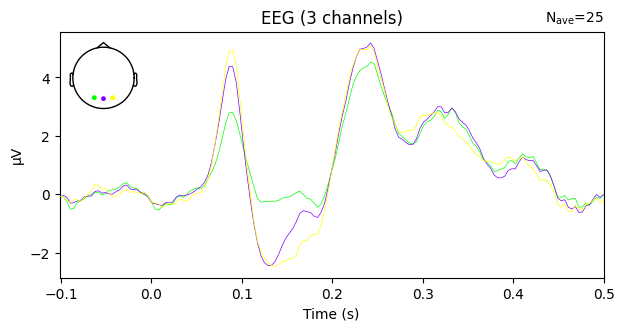

In [15]:
grand_av_pos4.plot(picks=['PO3','POz','PO4'],)

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


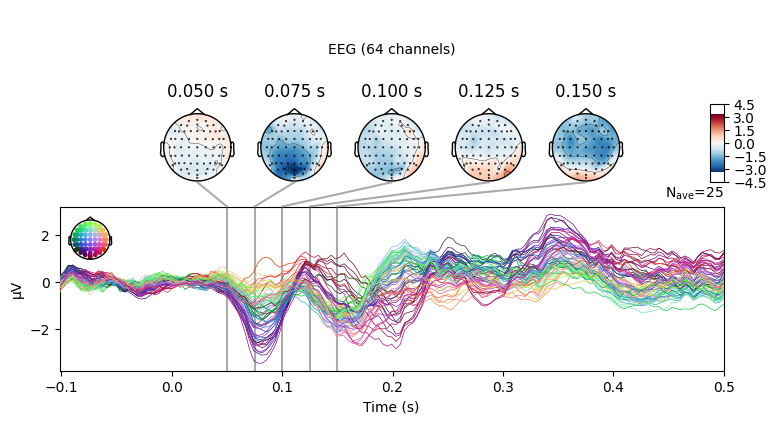

In [16]:
times = np.linspace(0.05, 0.15, 5)
grand_av_pos1.plot_joint(times=times)

In [10]:
times = np.linspace(0.08, 0.11, 1)
range_top = (-3,3)
topos = [grand_av_pos1,grand_av_pos2,grand_av_pos3,grand_av_pos4]
nombres = ['top_left','top_right','bottom_right','bottom_left']

for i,pos in enumerate(topos):
   fig = pos.plot_topomap(ch_type="eeg", times=times, colorbar=True,vlim=range_top)
   fig.savefig(nombres[i] + '_figure.png' )

In [18]:

""" 
Create df for plotting purposes
"""
position_names = ['Top Left','Top Right','Bottom Right','Bottom Left']

evokeds_data = []
evokeds_times= []
evokeds_subject = []
evokeds_position = []



for i, evos in enumerate(evokeds):
    for idx,ev in enumerate(evos):
        el_ev = ev.pick(['POz'])
        dat = el_ev.data.squeeze() * 1e6 
        tim = el_ev.times
        subji = np.repeat(subjects[i],len(dat))
        pos_nam = np.repeat(position_names[idx],len(dat))

        evokeds_data.extend(dat)
        evokeds_times.extend(tim)
        evokeds_subject.extend(subji)
        evokeds_position.extend(pos_nam)


evokeds_data = np.array(evokeds_data)
evokeds_times = np.array(evokeds_times)
evokeds_subject = np.array(evokeds_subject)
evokeds_position = np.array(evokeds_position)

# Create the df
zz_plot_df = pd.DataFrame({
    'subject': evokeds_subject,
    'times': evokeds_times,
    'position': evokeds_position,
    'amp': evokeds_data
})


In [29]:

zz_plot_df.to_csv(r'C:\Users\mvmigem\Documents\data\project_1\plotting_df\localiser_c1_plot.csv',index= False)


In [19]:
"""
***Aestetics***
"""
# load color palette
my_palette = sns.color_palette().as_hex()
sns.color_palette().as_hex()

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [28]:
""" 
Detailed erp plotting
"""
import matplotlib.lines as mlines

fig, axes = plt.subplots(1, figsize=(16, 10), sharey=True)

line_colours = [my_palette[0],my_palette[2],my_palette[1],my_palette[3]]
line_colours_up = ['#8ED973','#8ED973','#FFC000','#FFC000']
line_colours_LLL = [my_palette[1],'#FFC000',my_palette[9],'#8ED973']
line_styles = ['-','--','-','--']

sns.set_context("paper")

sns.lineplot(data=zz_plot_df, x='times', y='amp',hue='position',
             palette = line_colours_up ,ax=axes, linewidth=4,
             errorbar = 'se')
    # sns.lineplot(x=times, y=gwy,ax=axes,label = handles[idx],
    #              color=line_colours_up[idx], linestyle=line_styles[idx],linewidth=6)
# plt.rcParams['font.family'] = 'Segoe UI'
# plt.rcParams['font.weight'] = 'semibold'
legend = plt.legend(prop={'size':22},facecolor= 'white')

# plt.gca().set_facecolor('#C1E5F5')
sns.despine(offset=10, trim=True);
for i in range(1):
    axes.axhline(y=0, lw=1, c='black' )
    axes.axhline(y=4, ls ='--',lw=1, c='black' )
    axes.axvline(x=.05,ls='--',lw=1, c='black' )
    axes.axvline(x=.1,ls='--',lw=1, c='black' )
    axes.set_ylabel('µV', fontdict={'family': 'Segoe UI', 'weight' : 'semibold','size':28})
    axes.set_xlabel('time (s)',fontdict={'family': 'Segoe UI', 'weight' : 'semibold','size':28})

sns.axes_style("ticks")
# Adjust layout to prevent overlap
plt.tight_layout()
# Show the figure
plt.show()